# [IAPR 2020:][iapr2020] Project ‒ Special Project¶
**Author:** Quentin Talon & Albéric de Lajarte  
**Due date:** 28.05.2020  
[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract datas
We used pims : `pip install git+https://github.com/soft-matter/pims.git`, `skimage`, `os`, `numpy`, `matplotlib`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pims

data_base_path = os.path.join(os.pardir, 'data')
vid = pims.open(os.path.join(data_base_path, 'robot_parcours_1.avi'))
plt.figure(figsize = (10,10))
plt.imshow(vid[0])
print(vid)

<Frames>
Format: Huffyuv / HuffYUV
Source: ../data/robot_parcours_1.avi
Duration: 21.000 seconds
Frame rate: 2.000 fps
Length: 42 frames
Frame Shape: (480, 720, 3)



## Part 1: Still and moving image segmentation

### Background
We simply calculate the median along all the images. This reduces the noise and removes the moving object.

/Users/quentintalon/opt/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


Shape of vid_stack:(42, 480, 720, 3)
Shape of background:(480, 720, 3)


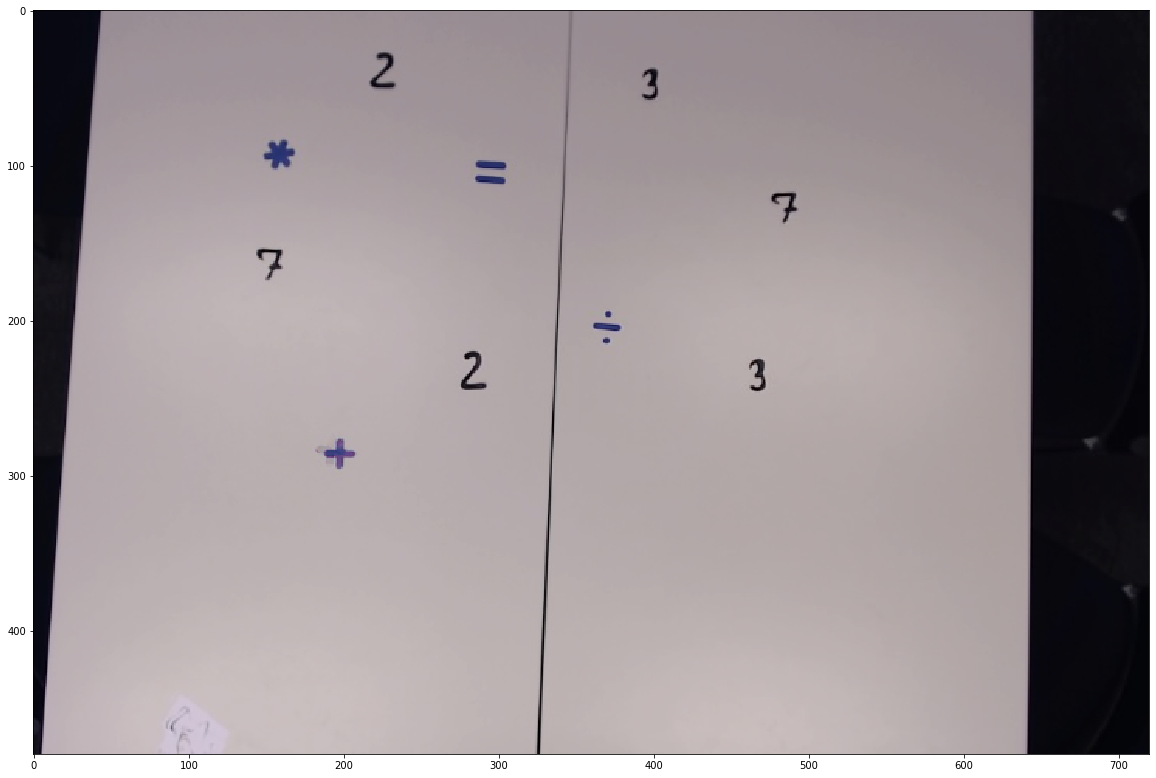

In [2]:
vid_stack = np.stack(vid, axis=0)
print("Shape of vid_stack:{}".format(vid_stack.shape))
background = np.median(vid_stack, axis=0).astype(int)
print("Shape of background:{}".format(background.shape))

plt.figure(figsize = (20,20))
plt.imshow(background)
plt.show()

### Moving part
We look at the red color, clean it a bit and look at his position, size and direction.  


/Users/quentintalon/opt/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


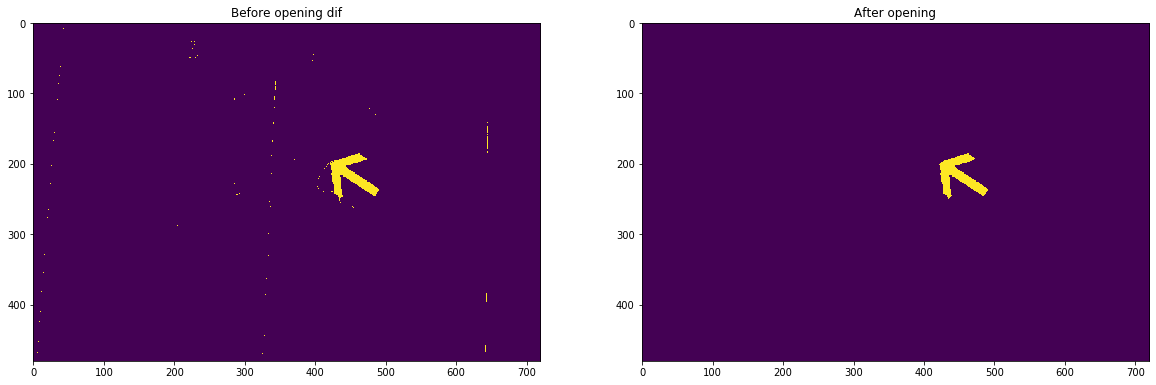

In [3]:
#Few tests.
from skimage.morphology import binary_opening, binary_closing, disk, label
from skimage.measure import regionprops

col_threshold = 100#How to choose it ???
fig, ax = plt.subplots(1,2, figsize=(20,10))
def red(v, th):
    r = v[:,:,0] > th
    g = v[:,:,1] < th
    b = v[:,:,2] < th
    return np.logical_and(r, g, b)
red_arrow = red(vid[9], col_threshold)
red_arrow_opened = binary_opening(red_arrow, selem=disk(2))

ax[0].imshow(red_arrow)
ax[0].set_title("Before opening dif")
ax[1].imshow(red_arrow_opened)
ax[1].set_title("After opening")
plt.show()


We had to create a home made rectangle mask

In [4]:
from skimage.draw import polygon
def rect2mask(x0, y0, l_x, l_y, ang, shape):#ang in rad
    hyp = 0.5*np.sqrt(l_x**2+l_y**2)
    rect_ang = np.arctan(l_x/l_y) + np.pi/2
    top_right = (x0+np.cos(ang+rect_ang)*hyp, y0+np.sin(ang+rect_ang)*hyp)
    top_left = (x0+np.cos(ang+np.pi-rect_ang)*hyp, y0+np.sin(ang+np.pi-rect_ang)*hyp)
    bottom_right = (x0+np.cos(ang-rect_ang)*hyp, y0+np.sin(ang-rect_ang)*hyp)
    bottom_left = (x0+np.cos(ang+np.pi+rect_ang)*hyp, y0+np.sin(ang+np.pi+rect_ang)*hyp)
    poly_coordinates = np.asarray([top_right, top_left, bottom_left, bottom_right])
    rr, cc = polygon(poly_coordinates[:,0], poly_coordinates[:,1], shape=shape)
    mask = np.zeros(shape, dtype=bool)
    mask[rr, cc, :] = [True, True, True]
    return mask

We create a mask for each frame and apply it on the background for each frame.  
So we have an image of the background were all what is out of the robot is set to 0.

In [5]:
def crop_image(img):
    mask = img>0
    if img.ndim==3:
        mask = mask.all(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    return img[np.ix_(mask1,mask0)][2:-2, 2:-2]

/Users/quentintalon/opt/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


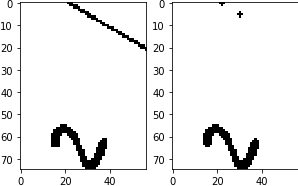

In [11]:
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

# Find region around the arrow
trajectory = [regionprops(label(binary_opening(red(v, col_threshold), disk(2))))[0] for v in vid]
trajectory_mask = [rect2mask(*point.centroid, point.major_axis_length, point.minor_axis_length, point.orientation, vid.frame_shape) for point in trajectory]

# Mask the part of the backgroung that is not in this region
hidden_background = [np.multiply(background,t) for t in trajectory_mask]
# Rotate the image prior to cropping
rotated_image = [rotate(hidden, angle = -np.rad2deg(region.orientation) , preserve_range=True, center = (region.centroid[1], region.centroid[0]) ).astype(np.uint8) for hidden, region in zip(hidden_background,trajectory)]
# Crop the part of the image that is not in this region
selected_background = [crop_image(rotated) for rotated in rotated_image]
# Use thresholding to have binary images
segmented_background = [np.where(rgb2gray(selected) > threshold_otsu(rgb2gray(selected)), 1, 0) for selected in selected_background]
# Use morphological closing to remove noise.
clean_background = [label(binary_closing(im, selem=disk(1))) for im in segmented_background]
# Visual check
fig, axes = plt.subplots(1, 2, figsize = (5, 10))
axes[0].imshow(segmented_background[16], cmap="gray")
axes[1].imshow(clean_background[16], cmap="gray")

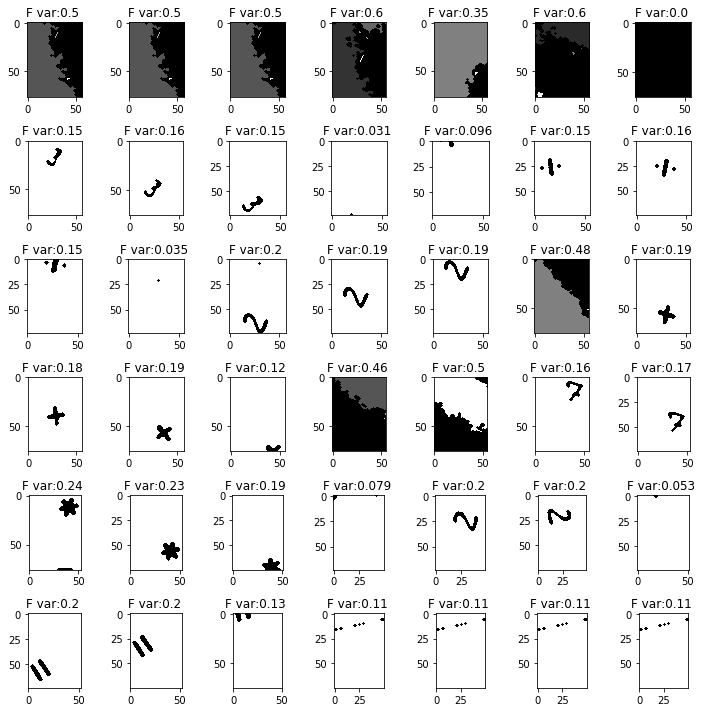

In [8]:
fig, axes = plt.subplots(6, 7, figsize = (10, 10))

for axe, seg, clean in zip(axes.flatten(), segmented_background, clean_background) :
    axe.imshow(clean, cmap="gray")
    feature = np.std(clean)
    
    symbol = "T" if feature > 13 else "F"
    axe.set_title(symbol + " var:{:.2} ".format(feature))
fig.tight_layout()
plt.show()

## Digits recognition

MNIST is based on grayscale image

In [9]:
import matplotlib.animation as animation
import matplotlib as mpl
def ani_frame(my_list):
    mpl.rcParams['savefig.pad_inches'] = 0
    fig = plt.figure( frameon=False)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_aspect('auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    im = ax.imshow(my_list[0])
    fig.set_size_inches((vid.frame_shape[1]/100, vid.frame_shape[0]/100))
    def update_img(n):
        im.set_data(my_list[n])
        return im
    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,range(len(my_list)))
    writer = animation.writers['ffmpeg'](fps=vid.frame_rate)
    ani.save('hidden_background.mp4',writer=writer,dpi=100)
    return ani

<Frames>
Format: Huffyuv / HuffYUV
Source: ../data/robot_parcours_1.avi
Duration: 21.000 seconds
Frame rate: 2.000 fps
Length: 42 frames
Frame Shape: (480, 720, 3)

<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: hidden_background.mp4
Duration: 21.000 seconds
Frame rate: 2.000 fps
Length: 42 frames
Frame Shape: (480, 720, 3)



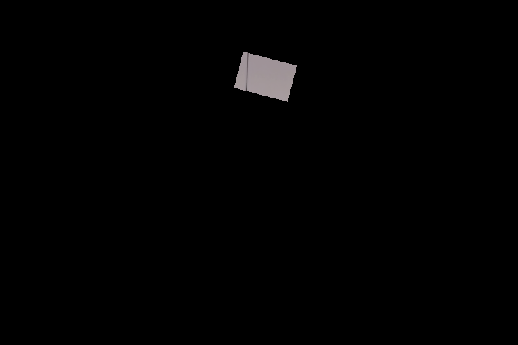

In [10]:
ani_frame(hidden_background)
print(vid)
vidi = pims.open("hidden_background.mp4")
print(vidi)